# Load data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import read_data
from scopus import get_affiliation_details, affiliation_scopus_details


data_dir = 'data'
results_dir = 'results'
figures_dir = f'{results_dir}/figures'


def load_author_data(data_dir):
    author_data = {}
    for affiliation in os.listdir(data_dir):
        affiliation_path = os.path.join(data_dir, affiliation)
        if os.path.isdir(affiliation_path):
            author_data[affiliation] = []
            for author_file in os.listdir(affiliation_path):
                if author_file.endswith('.json'):
                    author_path = os.path.join(affiliation_path, author_file)
                    author_data[affiliation].append(read_data(author_path))  # Replace with your read_data function
    return author_data


def load_institution_data(data_dir):
    return read_data(f'{data_dir}/affiliations.json')


author_data = load_author_data(data_dir)
institution_data = load_institution_data(data_dir)

### Data Cleaning (affiliations)

#### Top 10 affiliations listed by the universities top researchers
* We notice that Scopus sometimes identifies the School or Hospital of the author as the affiliation, instead of the University or Institution.
* All these schools and hospitals were identified and added to the list of affiliations for the university.
* We include foreign campus of the university such as `Monash University Malaysia`. However, we exclude institutions which are a joint venture with another university such as `Southeast University-Monash University Suzhou Joint Graduate School`.

In [2]:
def get_top_internal_affiliations(author_data, limit=10, save=False):
    top_affiliations = {}
    for affiliation, authors in author_data.items():
        top_affiliations[affiliation] = {}
        for author in authors:
            scopus_id = author['affiliation_id']
            if not scopus_id or scopus_id not in affiliation_scopus_details:
                continue
            elif scopus_id in top_affiliations[affiliation]:
                top_affiliations[affiliation][scopus_id] += 1
            else:
                top_affiliations[affiliation][scopus_id] = 1

        top_affiliations[affiliation] = dict(sorted(top_affiliations[affiliation].items(), key=lambda x: x[1], reverse=True)[:limit])

    if save:
        # Store in a file called `top_researcher_affiliation_per_university.txt`
        with open(f'{data_dir}/top_researcher_affiliation_per_university.txt', 'w') as f:
            for affiliation, affiliations in top_affiliations.items():
                f.write(f'Top affiliations for {affiliation}:\n')
                for affiliation_id, count in affiliations.items():
                    affiliation_details = get_affiliation_details(affiliation_id)
                    f.write(f'{affiliation_details["name"]}: {count}\n')
                f.write('\n')

    return top_affiliations

top_affiliations = get_top_internal_affiliations(author_data, save=True)

#### Find top 1000 collaborating institutions for each university

In [4]:
def get_top_collaborators(author_data, limit=200, show_details=False):
    collaborators = dict()
    for affiliation, authors in author_data.items():
        collaborators[affiliation] = dict()
        for author in authors:
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    # A co-author can have multiple affiliations
                    # Each affiliation is a potential collaborator and included
                    # with a normalised contribution
                    coauthor_affiliations = coauthor['affiliation_id']
                    for coauthor_affiliation in coauthor_affiliations:
                        if coauthor_affiliation in collaborators[affiliation]:
                            collaborators[affiliation][coauthor_affiliation] += 1 / len(coauthor_affiliations)
                        else:
                            collaborators[affiliation][coauthor_affiliation] = 1 / len(coauthor_affiliations)

    # Sort the collaborators for each university based ond documents
    top_collaborators = dict()
    for affiliation, collaborator_data in collaborators.items():
        if not show_details:
            top_collaborators[affiliation] = {
                affiliation_id: count for affiliation_id, count in sorted(collaborator_data.items(), key=lambda x: x[1], reverse=True)[:limit]
            }
        else:
            top_collaborators[affiliation] = dict()
            for affiliation_id, count in sorted(collaborator_data.items(), key=lambda x: x[1], reverse=True)[:limit]:
                affiliation_details = get_affiliation_details(affiliation_id)
                top_collaborators[affiliation][affiliation_id] = {
                    'name': affiliation_details['name'],
                    'document-count': count, # normalised for multiple affiliations
                    'city': affiliation_details['city'],
                    'country': affiliation_details['country']
                }
    return top_collaborators

top_collaborators = get_top_collaborators(author_data, limit=999, show_details=True)

#### Display Top 10 collaborators

In [ ]:
from IPython.display import display

# Only display the top 10 for each university
for affiliation, collaborators in top_collaborators.items():
    print(affiliation)
    top_10 = dict(sorted(collaborators.items(), key=lambda x: x[1]['document-count'], reverse=True)[:10])
    collab_df = pd.DataFrame(collaborators)
    display(collab_df)
    print()

## Plots

### Citations

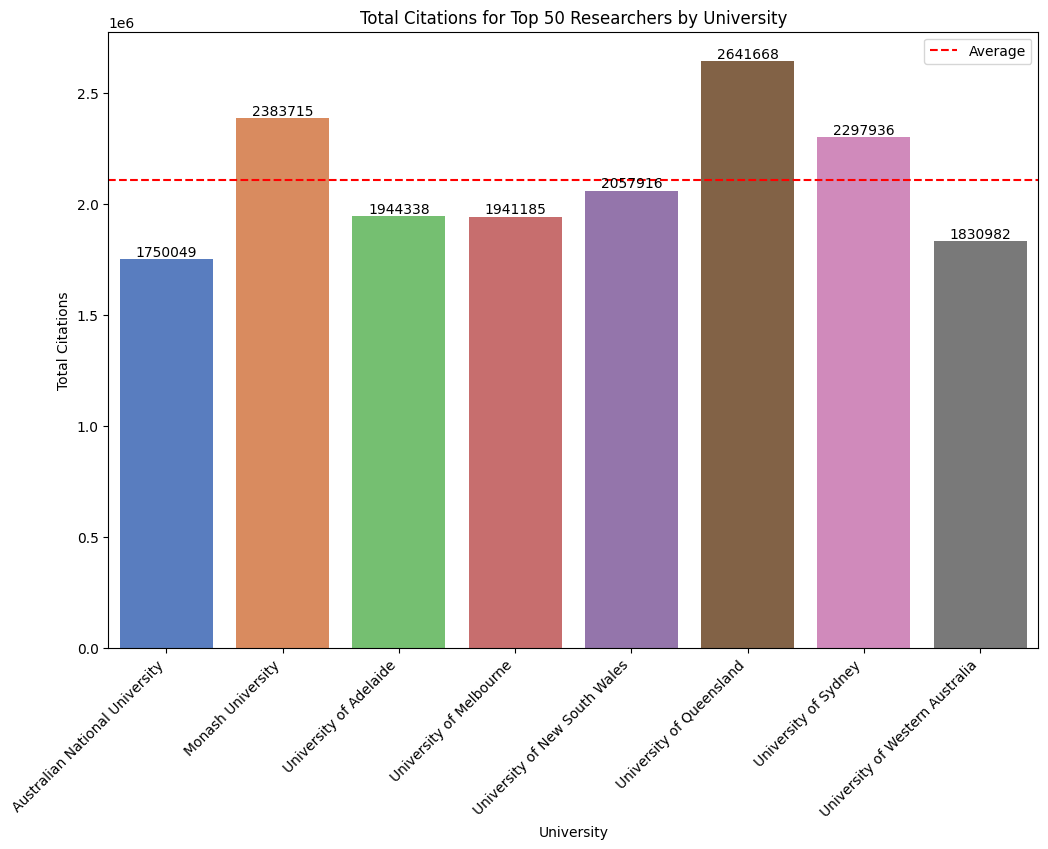

In [5]:
def plot_citations_by_university(author_data, save=None):
    citations_data = list()
    universities = list()
    for affiliation, authors in author_data.items():
        universities.append(affiliation)
        citations_data.append(0)
        for author in authors:
            citations_data[-1] += sum(pub['citations'] for pub in author['publications'])

    # Sort x and y values by x
    universities, citations_data = zip(*sorted(zip(universities, citations_data), key=lambda x: x[0]))

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=universities, y=citations_data, hue=universities, palette='muted', legend=False)
    plt.xlabel('University')
    plt.ylabel('Total Citations')
    plt.title(f'Total Citations for Top {len(authors)} Researchers by University')
    plt.xticks(rotation=45, ha='right')

    # Put numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    # Plot average as a line
    average_citations = sum(citations_data) / len(citations_data)
    plt.axhline(average_citations, color='red', linestyle='--', label='Average')
    plt.legend() # Show legend

    if save:
        plt.savefig(save)  # Save plot as PNG

    plt.show()

plot_citations_by_university(author_data, save=f'{figures_dir}/citations_by_university.png')

In [ ]:
def plot_median_citations_per_paper(author_data, save=None):
    citations_data = []
    for affiliation, authors in author_data.items():
        citations_per_paper = []
        for author in authors:
            for pub in author['publications']:
                citations_per_paper.append(pub['citations'])
        citations_data.append({
            'University': affiliation,
            'Median Citations per Paper': np.median(citations_per_paper)
        })
    citations_df = pd.DataFrame(citations_data)
    citations_df.sort_values('University', inplace=True)

    # Plotting using Seaborn (box plot)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='University', y='Median Citations per Paper', hue='University', legend=False, data=citations_df, palette='muted')
    plt.axhline(y=citations_df['Median Citations per Paper'].mean(), color='r', linestyle='--', label='Average')
    plt.legend()
    plt.xlabel('University')
    plt.ylabel('Median Number of Citations per Paper')
    plt.title(f'Median Number of Citations per Paper for the Top {len(list(author_data.values())[0])} Researchers by University')
    plt.xticks(rotation=45, ha='right')
    # Put numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

plot_median_citations_per_paper(author_data, save=f'{figures_dir}/median_citations_per_paper.png')

In [ ]:
def plot_mean_citations_per_paper(author_data, save=None):
    citations_data = []
    for affiliation, authors in author_data.items():
        citations_per_paper = []
        for author in authors:
            for pub in author['publications']:
                citations_per_paper.append(pub['citations'])
        citations_data.append({
            'University': affiliation,
            'Mean Citations per Paper': np.mean(citations_per_paper)
        })
    citations_df = pd.DataFrame(citations_data)
    citations_df.sort_values('University', inplace=True)

    # Plotting using Seaborn (box plot)
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='University', y='Mean Citations per Paper', hue='University', legend=False, data=citations_df, palette='muted')
    plt.axhline(y=citations_df['Mean Citations per Paper'].mean(), color='r', linestyle='--', label='Average')
    plt.legend()
    plt.xlabel('University')
    plt.ylabel('Mean Number of Citations per Paper')
    plt.title(f'Mean Number of Citations per Paper for the Top {len(list(author_data.values())[0])} Researchers by University')
    plt.xticks(rotation=45, ha='right')
    # Put numbers on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

plot_mean_citations_per_paper(author_data, save=f'{figures_dir}/mean_citations_per_paper.png')

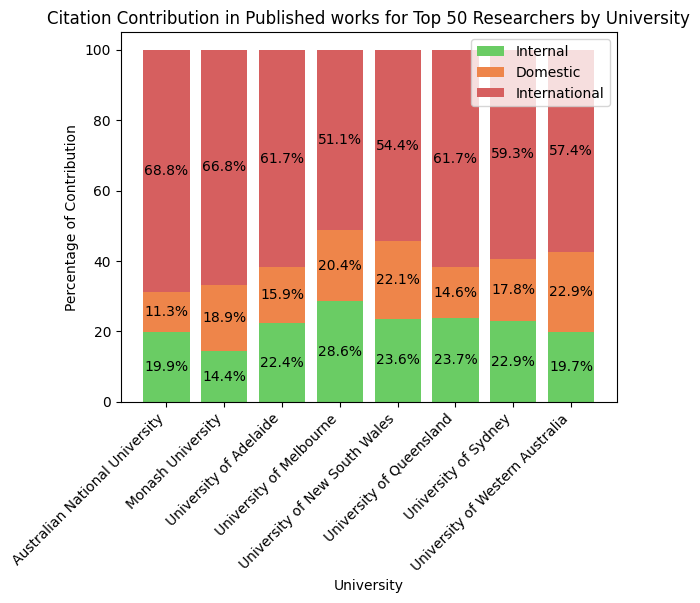

In [14]:
def plot_citation_contribution_by_university(institution_data, author_data, save=None):
    def get_contribution_category(affiliation_id, affiliation):
        institution_affiliation_set = set(institution_data[affiliation]['scopus_id'])
        coauthor_affiliation_set = set(affiliation_id)
        category = None
        if coauthor_affiliation_set & institution_affiliation_set:
            category = 'Internal'
        else:
            for coauthor_affiliation in coauthor_affiliation_set:
                if coauthor_affiliation not in affiliation_scopus_details:
                    continue
                elif affiliation_scopus_details[coauthor_affiliation]['country'] == institution_data[affiliation]['country']:
                    category = 'Domestic'
                    break
                else:
                    category = 'International'

        return category

    contribution_data = list()
    universities = list()
    for affiliation, authors in author_data.items():
        universities.append(affiliation)
        internal_contribution = 0
        domestic_contribution = 0
        international_contribution = 0
        for author in authors:
            for pub in author['publications']:
                citations_per_author = pub['citations'] / len(pub['authors'])
                for coauthor in pub['authors']:
                    category = get_contribution_category(coauthor['affiliation_id'], affiliation)
                    if category == 'Internal':
                        internal_contribution += citations_per_author
                    elif category == 'Domestic':
                        domestic_contribution += citations_per_author
                    elif category == 'International':
                        international_contribution += citations_per_author

        contribution_data.append({
            'University': affiliation,
            'Internal Contribution': internal_contribution,
            'Domestic Contribution': domestic_contribution,
            'International Contribution': international_contribution
        })

    contribution_df = pd.DataFrame(contribution_data)

    # Calculate the total number of contribution for each university
    contribution_df['Total Contribution'] = contribution_df['Internal Contribution'] + contribution_df['Domestic Contribution'] + contribution_df['International Contribution']

    # Calculate the percentage of each type of contribution
    contribution_df['Internal Contribution (%)'] = contribution_df['Internal Contribution'] / contribution_df['Total Contribution'] * 100
    contribution_df['Domestic Contribution (%)'] = contribution_df['Domestic Contribution'] / contribution_df['Total Contribution'] * 100
    contribution_df['International Contribution (%)'] = contribution_df['International Contribution'] / contribution_df['Total Contribution'] * 100

    # Sort x and y values by x
    contribution_df = contribution_df.sort_values('University')

    # Set the seaborn color palette
    sns.set_palette('muted')

    plt.bar(contribution_df['University'], contribution_df['Internal Contribution (%)'], color=sns.color_palette()[2], label='Internal')
    plt.bar(contribution_df['University'], contribution_df['Domestic Contribution (%)'], bottom=contribution_df['Internal Contribution (%)'], color=sns.color_palette()[1], label='Domestic')
    plt.bar(contribution_df['University'], contribution_df['International Contribution (%)'], bottom=contribution_df['Internal Contribution (%)'] + contribution_df['Domestic Contribution (%)'], color=sns.color_palette()[3], label='International')
    plt.xlabel('University')
    plt.ylabel('Percentage of Contribution')
    plt.title(f'Citation Contribution in Published works for Top {len(list(author_data.values())[0])} Researchers by University')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # Display the percentages on top of the bars
    for i, (internal, domestic, international) in enumerate(zip(contribution_df['Internal Contribution (%)'], contribution_df['Domestic Contribution (%)'], contribution_df['International Contribution (%)'])):
        plt.text(i, internal/2, f'{internal:.1f}%', ha='center', va='center', color='black')
        plt.text(i, internal + domestic/2, f'{domestic:.1f}%', ha='center', va='center', color='black')
        plt.text(i, internal + domestic + international/2, f'{international:.1f}%', ha='center', va='center', color='black')

    if save:
        plt.savefig(save)  # Save plot as PNG

    plt.show()

plot_citation_contribution_by_university(institution_data, author_data, save=f'{figures_dir}/citation_contribtion_by_university_stacked.png')

### Subject areas

In [ ]:
def plot_publications_by_subject_area(author_data, save=None):
    def publications_by_subject_area(author_data, university):
        return pd.DataFrame([{'University': university, 'Subject Area': subject['$'], 'Publication Count': 1}
                             for author in author_data[university]
                             for pub in author['publications']
                             for subject in author['subject_area']])

    universities = list(author_data.keys())[:8]
    aggregate_df = pd.concat([publications_by_subject_area(author_data, university) for university in universities])

    subject_counts_all = aggregate_df.groupby('Subject Area')['Publication Count'].sum().sort_values(ascending=False)
    sorted_subjects_all = subject_counts_all.index.tolist()

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Subject Area', y='Publication Count', hue='Subject Area', data=aggregate_df,
                estimator=np.sum, palette='muted', order=sorted_subjects_all)
    plt.xlabel('Subject Area')
    plt.ylabel('Number of Publications')
    plt.title(f'Aggregate Publications for Top {len(list(author_data.values())[0])} Researchers by Subject Area across 8 Universities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        save_as = f'{save.rsplit("/", 1)[0]}/aggregate_{save.rsplit("/", 1)[-1]}'
        plt.savefig(save_as)  # Save plot as PNG
    plt.show()

    plt.figure(figsize=(16, 20))

    # Sort universities alphabetically
    universities.sort()

    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        publications_df = publications_by_subject_area(author_data, university)

        subject_counts = publications_df.groupby('Subject Area')['Publication Count'].sum().sort_values(ascending=False)
        sorted_subjects = subject_counts.index.tolist()

        sns.barplot(x='Subject Area', y='Publication Count', hue='Subject Area', data=publications_df,
                    estimator=np.sum, palette='muted', ax=plt.gca(), order=sorted_subjects)
        plt.xlabel('Subject Area')
        plt.ylabel('Number of Publications')
        plt.title(f'Publications for Top {len(list(author_data.values())[0])} Researchers by Subject Area: {university}')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    if save:
        plt.savefig(save)  # Save plot as PNG

    plt.show()

plot_publications_by_subject_area(author_data, save=f'{figures_dir}/publications_by_subject_area.png')

### Temporal analysis

In [ ]:
def publications_over_time(author_data, save=None, exclude_years=[]):
    def publications_by_year(author_data, university):
        publications = []
        for author in author_data[university]:
            for pub in author['publications']:
                year = int(pub['cover_date'].split('-')[0])
                if year in exclude_years:
                    continue
                publications.append({'University': university, 'Year': year, 'Publication Count': 1})

        df = pd.DataFrame(publications)
        df = df.groupby(['University', 'Year']).sum().reset_index().sort_values(['University', 'Year'])
        return df

    universities = list(author_data.keys())
    aggregate_df = pd.concat([publications_by_year(author_data, university) for university in universities])

    # Sort x and y values by x
    universities.sort()
    aggregate_df = aggregate_df.sort_values(['University', 'Year'])

    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Year', y='Publication Count', hue='University', data=aggregate_df, palette='muted')
    plt.xlabel('Year')
    plt.ylabel('Number of Publications')
    plt.title(f'Publications from the Top {len(list(author_data.values())[0])} Researchers by Year')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        save_as = f'{save.rsplit("/", 1)[0]}/aggregate_{save.rsplit("/", 1)[-1]}'
        plt.savefig(save_as)
    plt.show()

    plt.figure(figsize=(16, 20))
    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        publications_df = publications_by_year(author_data, university)

        sns.lineplot(x='Year', y='Publication Count', data=publications_df, ax=plt.gca())
        plt.xlabel('Year')
        plt.ylabel('Number of Publications')
        plt.title(f'Publications from the Top {len(list(author_data.values())[0])} Researchers by Year: {university}')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig(save)

publications_over_time(author_data, save=f'{figures_dir}/publications_over_time.png')

In [ ]:
def citations_over_time(author_data, save=None, exclude_years=[]):
    def citations_by_year(author_data, university):
        citations = []
        for author in author_data[university]:
            for pub in author['publications']:
                year = int(pub['cover_date'].split('-')[0])
                if year in exclude_years:
                    continue
                citations.append({'University': university, 'Year': year, 'Citation Count': pub['citations']})

        df = pd.DataFrame(citations)
        df = df.groupby(['University', 'Year']).sum().reset_index().sort_values(['University', 'Year'])
        return df

    universities = list(author_data.keys())[:8]
    aggregate_df = pd.concat([citations_by_year(author_data, university) for university in universities])

    # Sort x and y values by x
    universities.sort()
    aggregate_df = aggregate_df.sort_values(['University', 'Year'])


    plt.figure(figsize=(12, 8))
    sns.lineplot(x='Year', y='Citation Count', hue='University', data=aggregate_df, palette='muted')
    plt.xlabel('Year')
    plt.ylabel('Number of Citations')
    plt.title(f'Citations received by the Top {len(list(author_data.values())[0])} Researchers by Year')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        save_as = f'{save.rsplit("/", 1)[0]}/aggregate_{save.rsplit("/", 1)[-1]}'
        plt.savefig(save_as)
    plt.show()

    plt.figure(figsize=(16, 20))
    for i, university in enumerate(universities):
        plt.subplot(4, 2, i+1)
        citations_df = citations_by_year(author_data, university)

        sns.lineplot(x='Year', y='Citation Count', data=citations_df, ax=plt.gca())
        plt.xlabel('Year')
        plt.ylabel('Number of Citations')
        plt.title(f'Citations received by the Top {len(list(author_data.values())[0])} Researchers by Year: {university}')
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig(save)

citations_over_time(author_data, save=f'{figures_dir}/citations_over_time.png')

### Authorship position analysis

In [ ]:
def plot_median_coauthors(author_data, save=None):
    coauthors_data = []
    for affiliation, authors in author_data.items():
        coauthor_counts = []
        for author in authors:
            coauthor_counts.extend(len(pub['authors']) for pub in author['publications'])
        coauthors_data.append({
            'University': affiliation,
            'Median Co-authors': np.median(coauthor_counts)
        })
    median_coauthors_df = pd.DataFrame(coauthors_data)
    median_coauthors_df.sort_values('University', inplace=True)

    # Plotting using Seaborn (box plot)
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='University', y='Median Co-authors', hue='University', legend=False, data=median_coauthors_df, palette='muted')
    plt.xlabel('University')
    plt.ylabel('Median Number of Co-authors per Paper')
    plt.title(f'Median Number of Co-authors per Paper for the Top {len(list(author_data.values())[0])} Researchers by University')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

plot_median_coauthors(author_data, save=f'{figures_dir}/median_coauthors.png')

In [ ]:
def authorship_position_analysis(author_data, save=None):
    position_data = []
    for affiliation, authors in author_data.items():
        first_count = 0
        middle_count = 0
        last_count = 0
        single_count = 0
        for author in authors:
            for pub in author['publications']:
                if len(pub['authors']) == 1:
                    single_count += 1
                elif pub['authors'][0]['scopus_id'] == author['scopus_id']:
                    first_count += 1
                elif pub['authors'][-1]['scopus_id'] == author['scopus_id']:
                    last_count += 1
                else:
                    middle_count += 1
        total_papers = first_count + middle_count + last_count + single_count
        if total_papers > 0:
            position_data.append({
                'University': affiliation,
                'First-authored (%)': (first_count / total_papers) * 100,
                'Middle-authored (%)': (middle_count / total_papers) * 100,
                'Last-authored (%)': (last_count / total_papers) * 100,
                'Single-authored (%)': (single_count / total_papers) * 100,
                'First-authored': first_count,
                'Middle-authored': middle_count,
                'Last-authored': last_count,
                'Single-authored': single_count
            })
    position_df = pd.DataFrame(position_data)
    position_df.sort_values('University', inplace=True)
    # Plotting using Matplotlib (pie chart)
    plt.figure(figsize=(10, 6))
    labels = ['First-authored\n({})'.format(position_df['First-authored'].sum().round(1)),
            'Middle-authored\n({})'.format(position_df['Middle-authored'].sum().round(1)),
            'Last-authored\n({})'.format(position_df['Last-authored'].sum().round(1)),
            'Single-authored\n({})'.format(position_df['Single-authored'].sum().round(1))]
    sizes = [position_df['First-authored'].sum(),
            position_df['Middle-authored'].sum(),
            position_df['Last-authored'].sum(),
            position_df['Single-authored'].sum()]
    colors = ['#66c2a5', '#e78ac3', '#fc8d62', '#a6d854']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
    plt.title(f'Authorship Position Analysis for the Top {len(list(author_data.values())[0])} Researchers')
    plt.axis('equal')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

authorship_position_analysis(author_data, f'{figures_dir}/aggregate_authorship_position_analysis.png')

In [ ]:
def authorship_position_trends(author_data, save=None):
    trends_data = []
    for affiliation, authors in author_data.items():
        first_counts = []
        middle_counts = []
        last_counts = []
        single_counts = []
        for author in authors:
            first_count = 0
            middle_count = 0
            last_count = 0
            single_count = 0
            for pub in author['publications']:
                if len(pub['authors']) == 1:
                    single_count += 1
                elif pub['authors'][0]['scopus_id'] == author['scopus_id']:
                    first_count += 1
                elif pub['authors'][-1]['scopus_id'] == author['scopus_id']:
                    last_count += 1
                else:
                    middle_count += 1
            first_counts.append(first_count)
            middle_counts.append(middle_count)
            last_counts.append(last_count)
            single_counts.append(single_count)
        total_papers = np.sum(first_counts) + np.sum(middle_counts) + np.sum(last_counts) + np.sum(single_counts)
        if total_papers > 0:
            trends_data.append({
                'University': affiliation,
                'First-authored': np.sum(first_counts),
                'Middle-authored': np.sum(middle_counts),
                'Last-authored': np.sum(last_counts),
                'Single-authored': np.sum(single_counts),
                'First-authored (%)': (np.sum(first_counts) / total_papers) * 100,
                'Middle-authored (%)': (np.sum(middle_counts) / total_papers) * 100,
                'Last-authored (%)': (np.sum(last_counts) / total_papers) * 100,
                'Single-authored (%)': (np.sum(single_counts) / total_papers) * 100
            })
    trends_df = pd.DataFrame(trends_data)
    trends_df = trends_df.sort_values(['University']).reset_index(drop=True)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='University', y='First-authored', data=trends_df, color='#66c2a5', label='First-authored')
    sns.barplot(x='University', y='Middle-authored', data=trends_df, bottom=trends_df['First-authored'], color='#e78ac3', label='Middle-authored')
    sns.barplot(x='University', y='Last-authored', data=trends_df, bottom=trends_df['First-authored'] + trends_df['Middle-authored'], color='#fc8d62', label='Last-authored')
    sns.barplot(x='University', y='Single-authored', data=trends_df, bottom=trends_df['First-authored'] + trends_df['Middle-authored'] + trends_df['Last-authored'], color='#a6d854', label='Single-authored')
    plt.xlabel('University')
    plt.ylabel('Number of Papers')
    plt.title(f'Authorship Position Analysis for the Top {len(list(author_data.values())[0])} Researchers')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Authorship Position', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add percentages as labels
    for index, row in trends_df.iterrows():
        plt.text(index, row['First-authored'] / 2, f'{row["First-authored"]:.0f}\n({row["First-authored (%)"]:.1f}%)', ha='center', va='center', color='black')
        plt.text(index, row['First-authored'] + row['Middle-authored'] / 2, f'{row["Middle-authored"]:.0f}\n({row["Middle-authored (%)"]:.1f}%)', ha='center', va='center', color='black')
        plt.text(index, row['First-authored'] + row['Middle-authored'] + row['Last-authored'] / 2, f'{row["Last-authored"]:.0f}\n({row["Last-authored (%)"]:.1f}%)', ha='center', va='center', color='black')
        plt.text(index, row['First-authored'] + row['Middle-authored'] + row['Last-authored'] + row['Single-authored'] / 2, f'{row["Single-authored"]:.0f}\n({row["Single-authored (%)"]:.1f}%)', ha='center', va='center', color='black')

    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

authorship_position_trends(author_data, f'{figures_dir}/authorship_position_analysis.png')

### Collaboration network

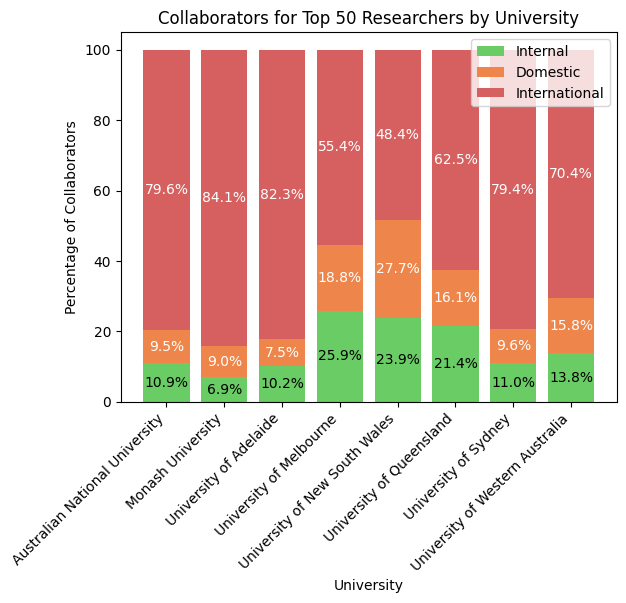

In [15]:
def plot_collaborators_by_university(institution_data, author_data, save=None):
    def get_collaborator_category(affiliation_id, affiliation):
        institution_affiliation_set = set(institution_data[affiliation]['scopus_id'])
        coauthor_affiliation_set = set(affiliation_id)
        category = None
        if coauthor_affiliation_set & institution_affiliation_set:
            category = 'Internal'
        else:
            for coauthor_affiliation in coauthor_affiliation_set:
                if coauthor_affiliation not in affiliation_scopus_details:
                    continue
                elif affiliation_scopus_details[coauthor_affiliation]['country'] == institution_data[affiliation]['country']:
                    category = 'Domestic'
                    break
                else:
                    category = 'International'

        return category

    collaborator_data = list()
    universities = list()
    for affiliation, authors in author_data.items():
        universities.append(affiliation)
        internal_collaborators = 0
        domestic_collaborators = 0
        international_collaborators = 0
        for author in authors:
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    category = get_collaborator_category(coauthor['affiliation_id'], affiliation)
                    if category == 'Internal':
                        internal_collaborators += 1
                    elif category == 'Domestic':
                        domestic_collaborators += 1
                    elif category == 'International':
                        international_collaborators += 1

        collaborator_data.append({
            'University': affiliation,
            'Internal Collaborators': internal_collaborators,
            'Domestic Collaborators': domestic_collaborators,
            'International Collaborators': international_collaborators
        })

    collaborator_df = pd.DataFrame(collaborator_data)

    # Calculate the total number of collaborators for each university
    collaborator_df['Total Collaborators'] = collaborator_df['Internal Collaborators'] + collaborator_df['Domestic Collaborators'] + collaborator_df['International Collaborators']

    # Calculate the percentage of each type of collaborator
    collaborator_df['Internal Collaborators (%)'] = collaborator_df['Internal Collaborators'] / collaborator_df['Total Collaborators'] * 100
    collaborator_df['Domestic Collaborators (%)'] = collaborator_df['Domestic Collaborators'] / collaborator_df['Total Collaborators'] * 100
    collaborator_df['International Collaborators (%)'] = collaborator_df['International Collaborators'] / collaborator_df['Total Collaborators'] * 100

    # Sort x and y values by x
    collaborator_df = collaborator_df.sort_values('University')

    # Set the seaborn color palette
    sns.set_palette('muted')

    plt.bar(collaborator_df['University'], collaborator_df['Internal Collaborators (%)'], color=sns.color_palette()[2], label='Internal')
    plt.bar(collaborator_df['University'], collaborator_df['Domestic Collaborators (%)'], bottom=collaborator_df['Internal Collaborators (%)'], color=sns.color_palette()[1], label='Domestic')
    plt.bar(collaborator_df['University'], collaborator_df['International Collaborators (%)'], bottom=collaborator_df['Internal Collaborators (%)'] + collaborator_df['Domestic Collaborators (%)'], color=sns.color_palette()[3], label='International')
    plt.xlabel('University')
    plt.ylabel('Percentage of Collaborators')
    plt.title(f'Collaborators for Top {len(list(author_data.values())[0])} Researchers by University')
    plt.xticks(rotation=45, ha='right')
    plt.legend()

    # Display the percentages on top of the bars
    for i, (internal, domestic, international) in enumerate(zip(collaborator_df['Internal Collaborators (%)'], collaborator_df['Domestic Collaborators (%)'], collaborator_df['International Collaborators (%)'])):
        plt.text(i, internal/2, f'{internal:.1f}%', ha='center', va='center', color='black')
        plt.text(i, internal + domestic/2, f'{domestic:.1f}%', ha='center', va='center', color='white')
        plt.text(i, internal + domestic + international/2, f'{international:.1f}%', ha='center', va='center', color='white')

    if save:
        plt.savefig(save)  # Save plot as PNG

    plt.show()

plot_collaborators_by_university(institution_data, author_data, save=f'{figures_dir}/collaborators_by_university_stacked.png')

Country not found: Palestine


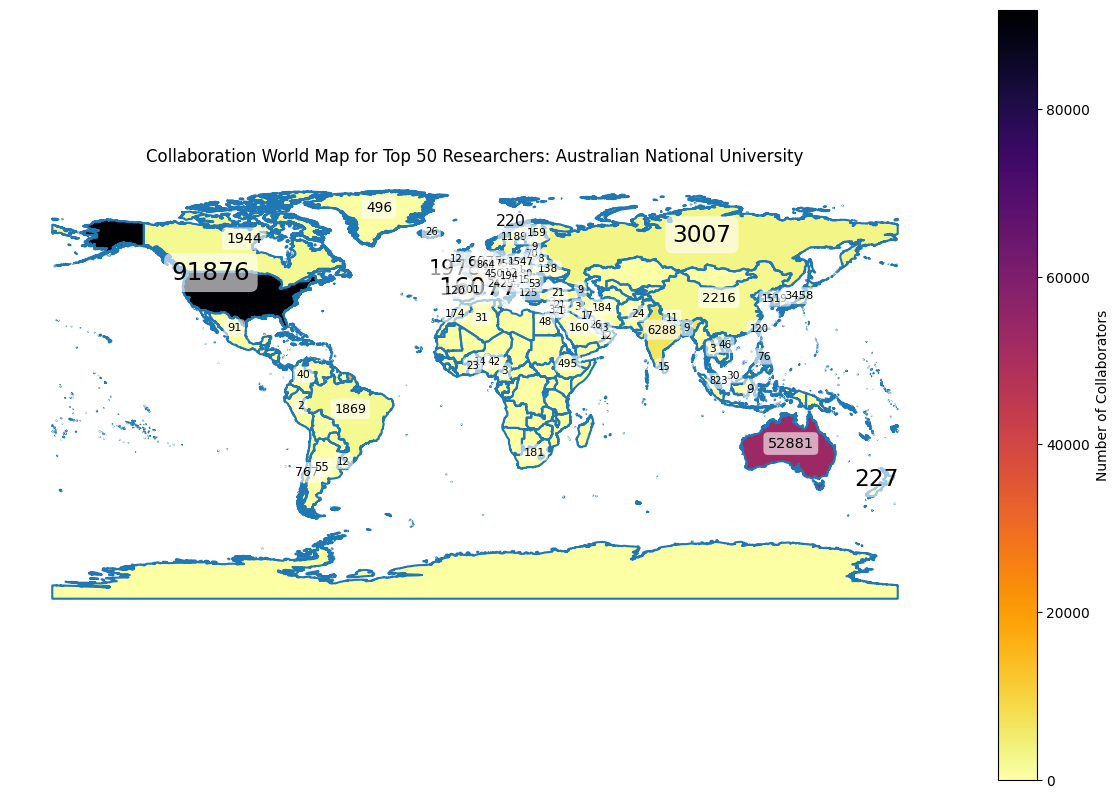

Country not found: Palestine


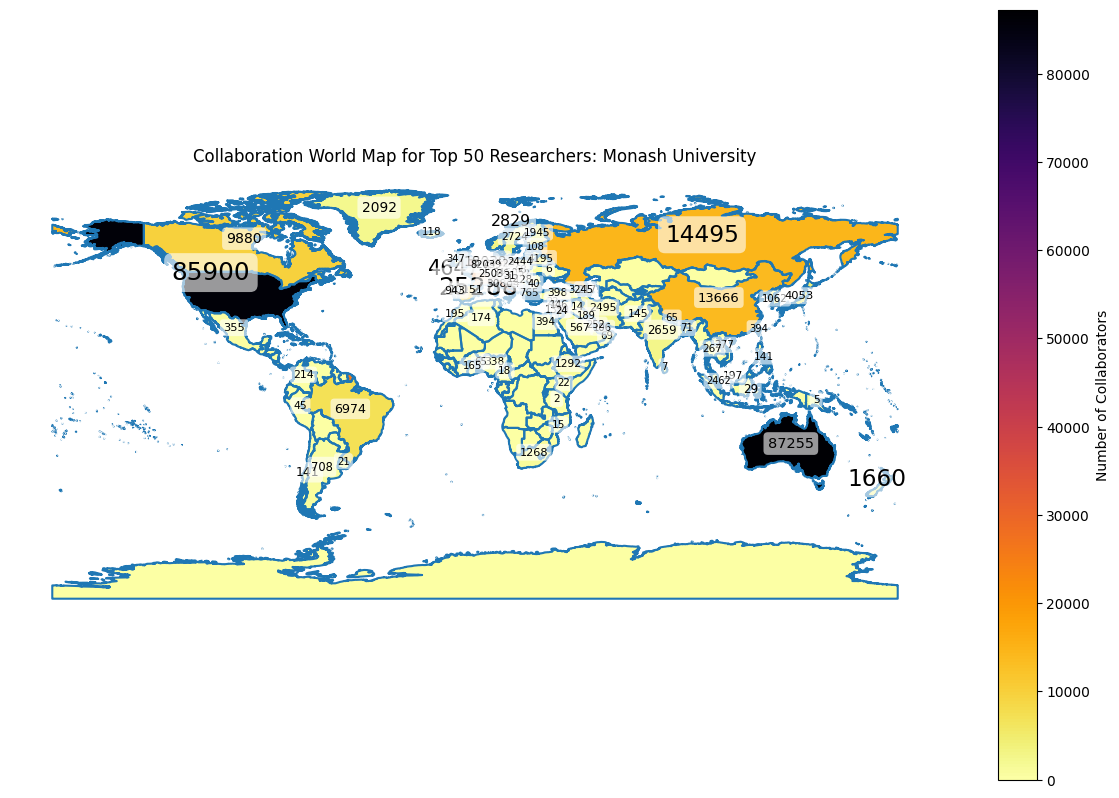

Country not found: Palestine


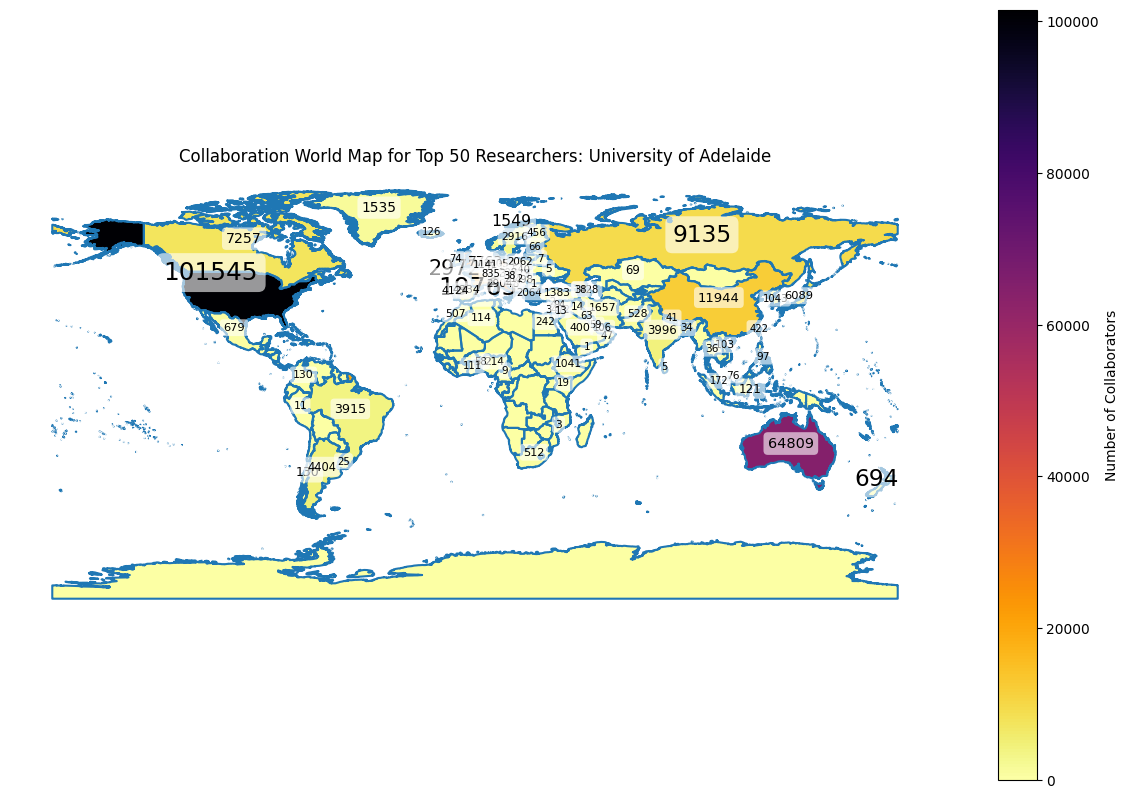

Country not found: Palestine


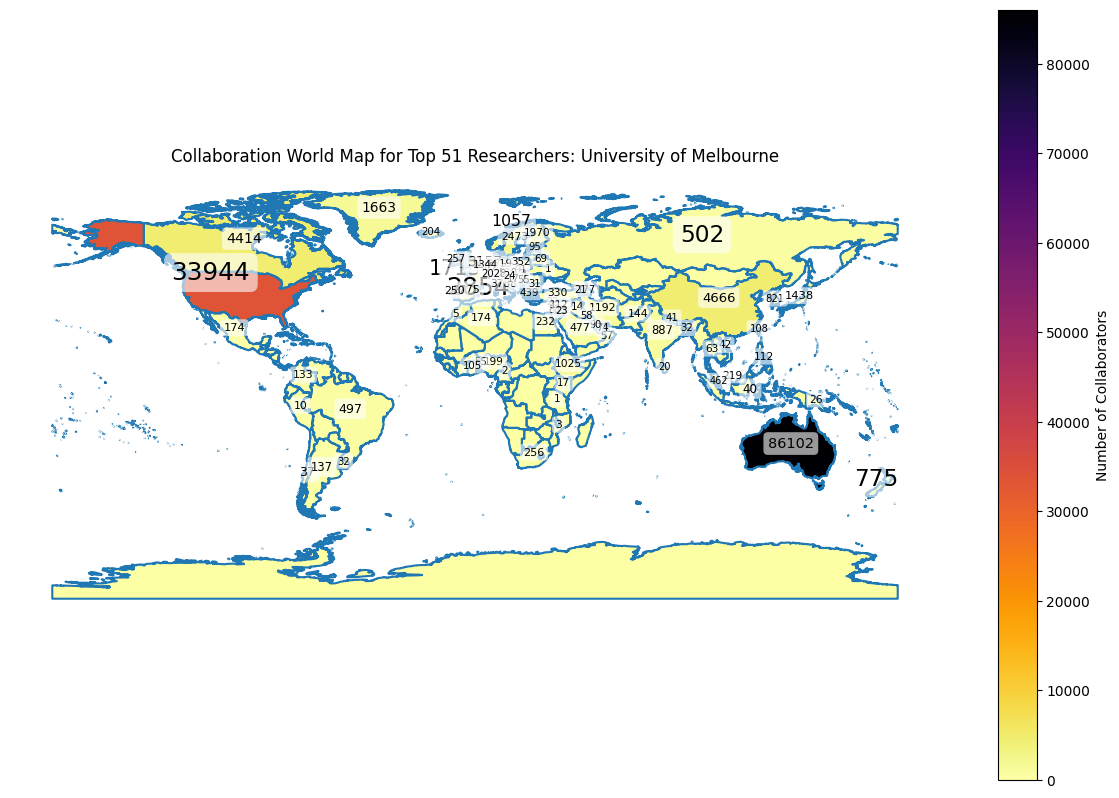

Country not found: Palestine


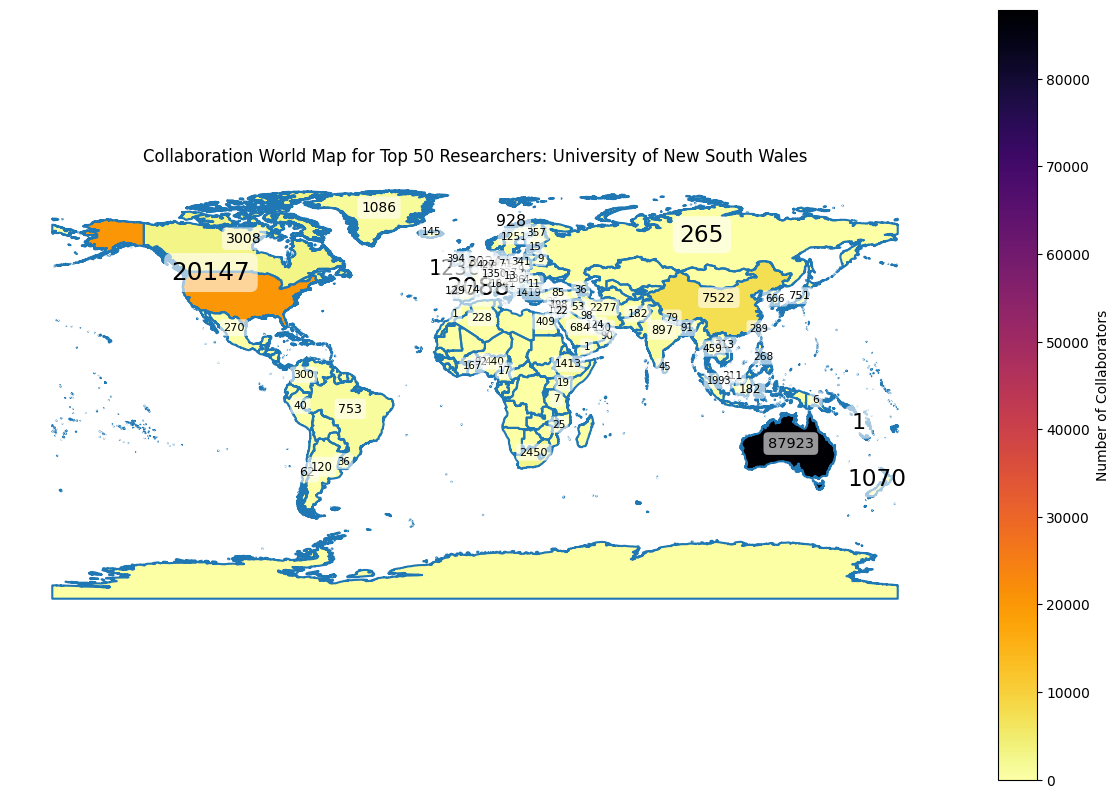

Country not found: Palestine


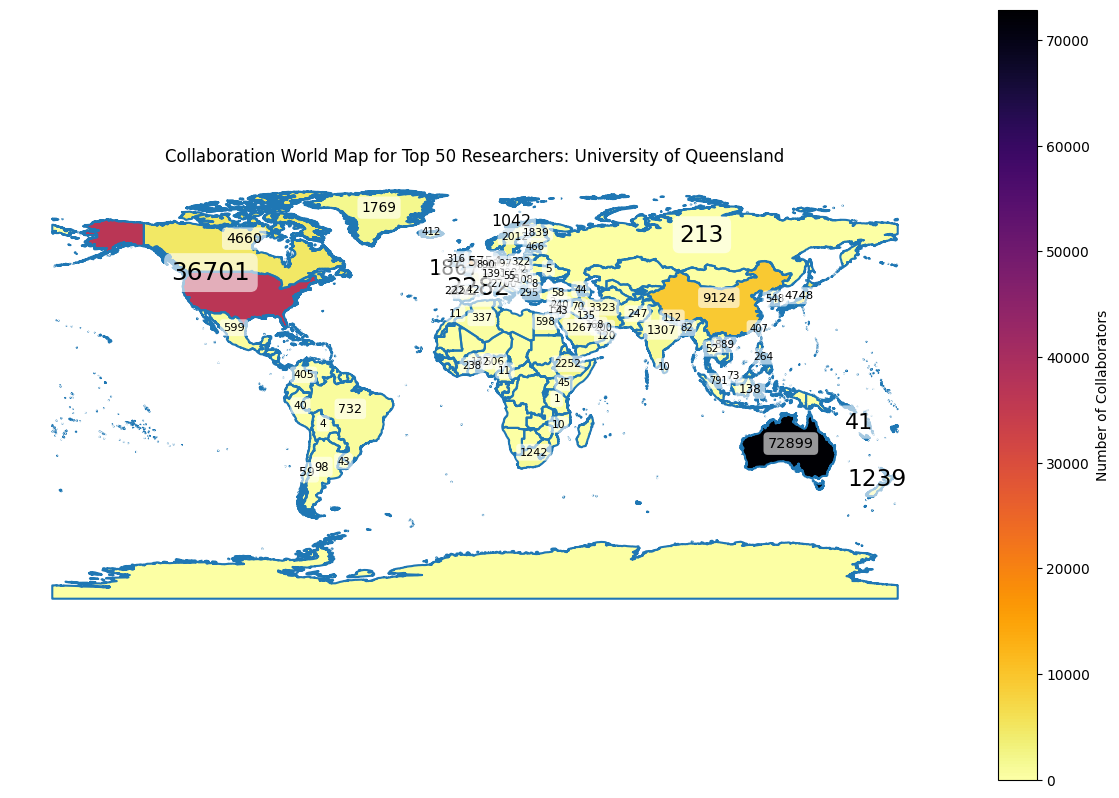

Country not found: Palestine


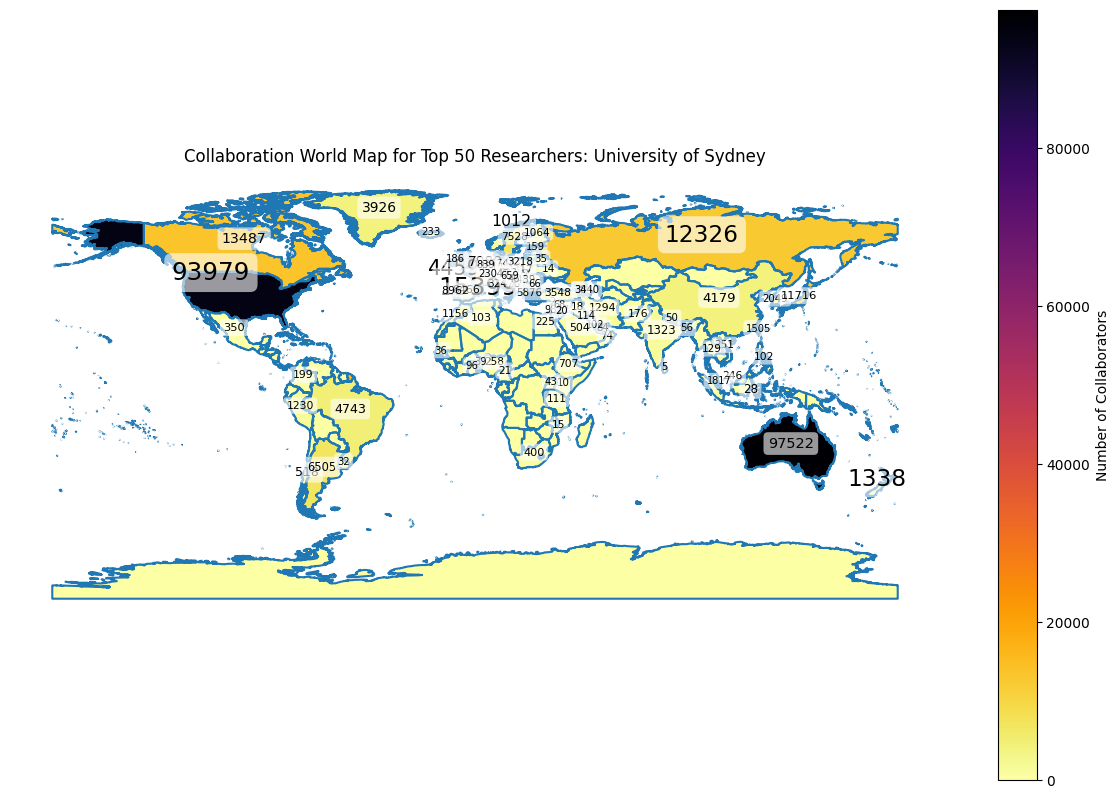

Country not found: Palestine


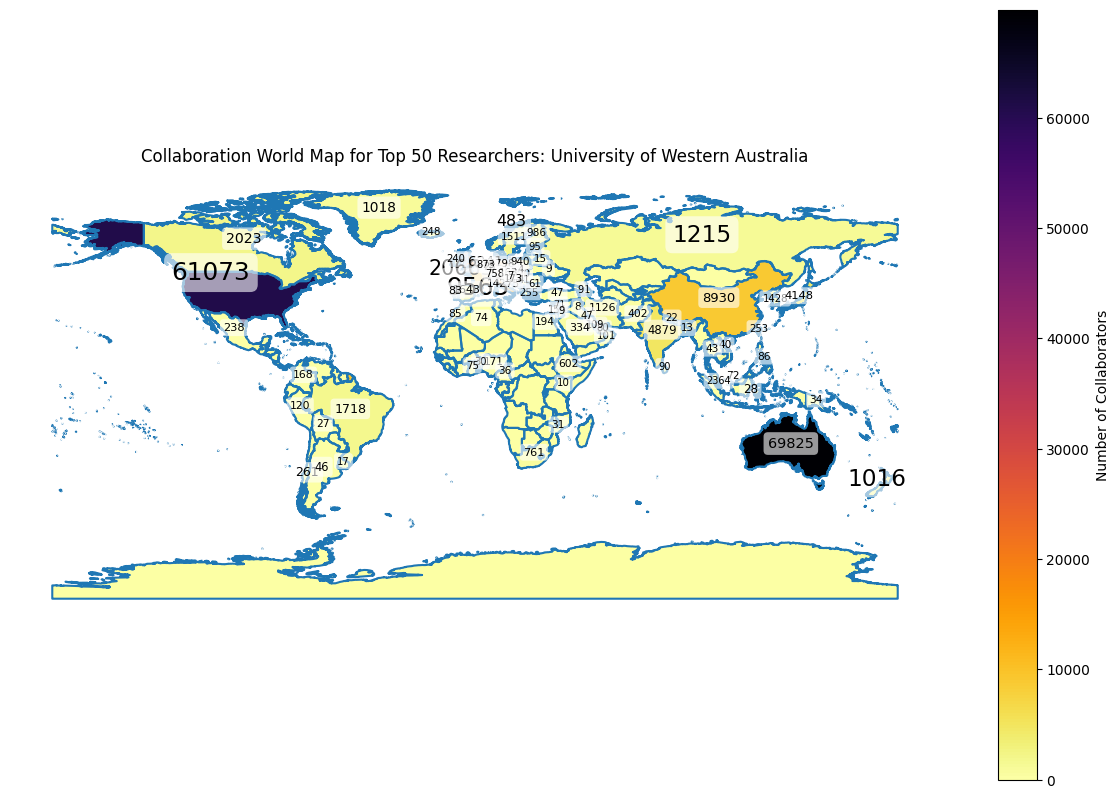

In [11]:
from scopus import affiliation_scopus_details
import geopandas as gpd
import matplotlib.pyplot as plt

# Data for territories was sourced from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/
# It identifies multiple territories differently, kindly read their documentation for more information.

# Data for geographies is stored under incorrect names in the world dataframe
replace_countries = {
    'United States': 'United States of America',
    'Virgin Islands (U.S.)': 'United States of America',
    'Russian Federation': 'Russia',
    'Serbia': 'Republic of Serbia',
    'Czech Republic': 'Czechia',
    'Hong Kong': 'China',
    'Viet Nam': 'Vietnam',
    'Tanzania': 'United Republic of Tanzania'
}

# Contains all countries in the world
world = gpd.read_file("ne_10m_admin_0_sovereignty.zip")

def plot_choropleth_worldmap(countries, title, save=None):
    world['count'] = 0
    for country in set(countries):
        if country in replace_countries:
            official_name = replace_countries[country]
        else:
            official_name = country
        # Create a new column called count which contains count of each country
        if not world.loc[world['SOVEREIGNT'] == official_name].empty:
            world.loc[world['SOVEREIGNT'] == official_name, 'count'] = countries.count(country)
        elif country is not None:
            print(f"Country not found: {country}")

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    world.boundary.plot(ax=ax)
    world.plot(column='count', ax=ax, legend=True, legend_kwds={'label': "Number of Collaborators"}, cmap='inferno_r')

    # Add text annotations
    min_size = 7
    max_size = 18
    max_diag = max(row['geometry'].envelope.length for idx, row in world.iterrows() if row['count'] > 0)
    for idx, row in world.iterrows():
        if row['count'] > 0:
            # Calculate font size based on the diagonal length of the bounding box
            diag = row['geometry'].envelope.length
            font_size = min_size + (diag / max_diag) * (max_size - min_size)

            plt.annotate(
                text=row['count'],
                xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                horizontalalignment='center',
                fontsize=font_size,
                color='black',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.3')
            )

    if title:
        plt.title(title)
    ax.set_axis_off()
    if save:
        plt.savefig(save)
    plt.show()
    world.drop(columns=['count'], inplace=True)

def plot_collaboration_world_map(author_data, save=None):
    def plot_collaboration_data(author_data, university, save):
        countries = []
        for author in author_data[university]:
            for pub in author['publications']:
                for coauthor in pub['authors']:
                    coauthor_primary_affiliation = coauthor['affiliation_id'][0] if coauthor['affiliation_id'] else None
                    if coauthor_primary_affiliation in affiliation_scopus_details:
                        country = affiliation_scopus_details[coauthor_primary_affiliation]['country']
                        countries.append(country)

        plot_choropleth_worldmap(countries, f'Collaboration World Map for Top {len(author_data[university])} Researchers: {university}', save)

    universities = list(author_data.keys())
    universities.sort()
    for university in universities:
        if save:
            save_as = f'{save.rsplit(".", 1)[0]}_{university.lower().replace(" ", "_")}.{save.rsplit(".", 1)[1]}'
        else:
            save_as = None
        plot_collaboration_data(author_data, university, save_as)

# Assuming author_data and figures_dir are defined elsewhere
plot_collaboration_world_map(author_data, f'{figures_dir}/collaboration_choropleth_worldmap.png')

### Brief Summary

In [ ]:
def comparison_metrics(author_data):
    metrics_data = []
    for affiliation, authors in author_data.items():
        total_citations = 0
        total_publications = 0
        citations_per_paper = []
        for author in authors:
            total_citations += sum(pub['citations'] for pub in author['publications'])
            total_publications += len(author['publications'])
            citations_per_paper.extend(pub['citations'] for pub in author['publications'])
        metrics_data.append({
            'University': affiliation,
            'Total Citations': total_citations,
            'Total Publications': total_publications,
            'Median Citations per Paper': np.median(citations_per_paper) if citations_per_paper else 0
        })
    metrics_df = pd.DataFrame(metrics_data)
    return metrics_df

metrics_df = comparison_metrics(author_data)
metrics_df